# In this notebook we are going to build a music recommendation engine that would reccomend artists based on the lyrics of their songs. 

### First off we import our libraries

In [57]:
import lyricsgenius
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
import requests
from urllib.request import urlopen
import bs4
from bs4 import BeautifulSoup
import re
import lxml.html
from lxml import html
from datetime import datetime, timedelta
import time
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import json
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

nltk.download('stopwords')
stop = stopwords.words('english')
sno = SnowballStemmer('english')
secrets = json.load(open('secrets.json','r'))

genius = lyricsgenius.Genius(secrets['genius_key'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/efrancois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Here we scrape a list of 100 rappers from Genuis

In [58]:
dom = lxml.html.fromstring(requests.get('https://genius.com/discussions/22873-Greatest-100-rappers').content)
rappers = [x for x in dom.xpath('//li/text()')]
rappers = [i for i in rappers if '\n' not in i]

print(rappers)

['Run-D.M.C.', 'Public Enemy', '2Pac', 'Eric B. & Rakim', 'Jay-Z', 'OutKast', 'N.W.A', 'Notorious B.I.G.', 'Grandmaster Flash & the Furious Five', 'A Tribe Called Quest', 'Nas', 'Ice Cube', 'LL Cool J', 'De La Soul', 'Kanye West', 'Scarface', 'Big Daddy Kane', 'Dr. Dre', 'Wu-Tang Clan', 'Eminem', 'UGK', 'Boogie Down Productions', 'The Beastie Boys', 'Slick Rick', 'EPMD', 'Snoop Dogg', 'MC Lyte', 'Gang Starr', 'Afrika Bambaataa', 'Kool G Rap', 'Kurtis Blow', 'The Roots', 'E-40', 'Common', 'The Jungle Brothers', 'Whodini', 'Ghostface Killah', 'Lauryn Hill', 'Eightball & MJG', 'Goodie MOB', 'Too $hort', 'Bone Thugs N Harmony', 'Mos Def', 'Salt N Pepa', 'Busta Rhymes', 'Digital Underground', 'Lil Wayne', 'Pete Rock & CL Smooth', 'The Fugees', 'DJ Jazzy Jeff & the Fresh Prince', 'T.I.', 'Queen Latifah', 'Raekwon', 'The Cold Crush Brothers', 'Redman', 'Eazy-E', 'Talib Kweli', 'Lil Kim', 'Ludacris', 'Naughty By Nature', 'Little Brother', 'Heavy D', 'Geto Boys', 'Jean Grae', 'Cypress Hill', 'D

### We find some more artists from billboard top 100 artists in the last "3" years

In [59]:
base_url = "https://www.billboard.com/charts/artist-100/"
pop_big = []
for n in range(20):
    d = (datetime.now() - timedelta(days=60*n)).strftime('%Y-%m-%d')
    dom2 = lxml.html.fromstring(requests.get(base_url + d).content)
    pop = [x for x in dom2.xpath('//*[@class="chart-list-item__title-text"]/a/text()')]
    pop = [i[1:-1] for i in pop]
    pop_big += pop
    time.sleep(.1)
pop_big = list(set(pop_big))

print(pop_big)

['Young Thug', 'DJ Khaled', 'XXXTENTACION', 'Swae Lee', 'Lady Gaga', 'Alan Jackson', 'Lil Wayne', 'Jason Derulo', 'Kip Moore', 'Kendrick Lamar', 'John Mayer', 'Paramore', 'Florence + The Machine', '2 Chainz', 'Meghan Trainor', 'John Legend', 'Scotty McCreery', 'Paul McCartney', 'The Chainsmokers', 'twenty one pilots', 'Michael Buble', '5 Seconds Of Summer', 'Coldplay', 'Sarah Brightman', 'Silverstein', 'Sturgill Simpson', 'Camila Cabello', 'Wiz Khalifa', 'Rend Collective', 'Taking Back Sunday', 'Zedd', 'Adele', 'G-Eazy', 'Anne-Marie', 'Hailee Steinfeld', 'Hozier', 'D.R.A.M.', 'Old Dominion', 'Mariah Carey', 'Iggy Azalea', 'Lorde', 'The Raconteurs', 'Sheryl Crow', 'Big K.R.I.T.', 'Garth Brooks', 'Desiigner', 'Jon Bellion', 'Jon Pardi\n', 'PnB Rock', 'Trippie Redd', 'XXXTENTACION\n', 'Five Finger Death Punch', 'Childish Gambino', 'Brett Young', 'Between The Buried And Me', 'Zara Larsson', 'Rihanna', ' Frank Ocean', 'Brothers Osborne', 'Dua Lipa', 'DNCE', 'Banks', 'Liam Payne', 'George Mi

### We do same for some dance artists. 



In [60]:
dom3 = lxml.html.fromstring(requests.get('https://www.billboard.com/articles/news/dance/8504278/billboard-dance-100-2019').content)
electronic = [x for x in dom3.xpath('//p/strong/text()')]



print(electronic)

['100. Bob Moses', '99. Lost Kings', '98. TOKiMONSTA', '97. Slushii', '96. Whethan', '95. Petit Biscuit', '94. Nina Kraviz', '93. CamelPhat', '92. Carnage', '91. Netsky', '90. Jax Jones', '89. The Martinez Brothers', '88. Felix Jaehn', '87. Showtek', '86. Lost Frequencies', '85. Deorro', '84. Marco Carola', '83. Jai Wolf', '82. NERVO', '81. Fisher', '80. Seven Lions', '79. MK', '78. Loud Luxury', '77. Nicky Romero', '76. Cash Cash', '75. Jonas Blue', '74. GRiZ', '73. Sofi\xa0Tukker', '72. 3LAU', '71. Alok', '70. SNAILS', '69. Madeon', '68. Maceo Plex', '67. Kayzo', '66. Big Gigantic', '65. KSHMR', '64. Richie Hawtin', '63. Oliver Heldens', '62. Adam Beyer', '61. ZHU', '60. Jauz', '59. Pretty Lights', '58. Matoma', '57. Black Coffee', '56. San Holo', '55. Gryffin', '54. Cashmere Cat', '53. Mura Masa', '52. W&W', '51. NGHTMRE', '50. Bonobo', '49. Robin Schulz', '48. Tchami', '47. R3hab', '46. Louis The Child', '45. Jamie Jones', '44. Cheat Codes', '43. RL Grime', '42. Yellow Claw', '41. 

#### The data that are being scraped most often than not are dirty with HTML tags such as white spaces and the break tag and also some other irrevalant information. Therefore they are cleaned to return a a list of just the name of the artists in a list

In [61]:
no_words = ['Top Gig of 2018:', 'Outlook:', 'Notable Stat:','Contributors: ']
electronic=[i for i in electronic if not any(words in i for words in no_words)]

electronic_fixed = []
for elec in electronic:
    electronic_fixed.append('. '.join(elec.split('. ')[1:]))
    
print(electronic_fixed)

['Bob Moses', 'Lost Kings', 'TOKiMONSTA', 'Slushii', 'Whethan', 'Petit Biscuit', 'Nina Kraviz', 'CamelPhat', 'Carnage', 'Netsky', 'Jax Jones', 'The Martinez Brothers', 'Felix Jaehn', 'Showtek', 'Lost Frequencies', 'Deorro', 'Marco Carola', 'Jai Wolf', 'NERVO', 'Fisher', 'Seven Lions', 'MK', 'Loud Luxury', 'Nicky Romero', 'Cash Cash', 'Jonas Blue', 'GRiZ', 'Sofi\xa0Tukker', '3LAU', 'Alok', 'SNAILS', 'Madeon', 'Maceo Plex', 'Kayzo', 'Big Gigantic', 'KSHMR', 'Richie Hawtin', 'Oliver Heldens', 'Adam Beyer', 'ZHU', 'Jauz', 'Pretty Lights', 'Matoma', 'Black Coffee', 'San Holo', 'Gryffin', 'Cashmere Cat', 'Mura Masa', 'W&W', 'NGHTMRE', 'Bonobo', 'Robin Schulz', 'Tchami', 'R3hab', 'Louis The Child', 'Jamie Jones', 'Cheat Codes', 'RL Grime', 'Yellow Claw', 'Solomun', 'Dillon Francis', 'Rezz', 'Don Diablo', 'Zeds Dead', 'Alison Wonderland', 'Illenium', 'Clean Bandit', 'Porter Robinson', 'Alan Walker', 'Afrojack', '', 'Disclosure', 'Carl Cox', 'Galantis', 'Eric Prydz', 'Kaskade', 'Justice', 'Bass

### Then we just add all our artists together into one list

In [62]:
artists=rappers+pop_big+electronic_fixed

artists = list(set(artists))

len(artists)


622

### Optional step (not recommended) 

In [63]:

artists = [art.replace('The Jungle Brothers', 'Jungle Brothers') for art in artists]
artists = [art.replace('The Funky Four+1', 'Funky Four Plus One') for art in artists]
artists = [art.replace('Kool Keith/Dr. Octagon', 'Kool Keith') for art in artists]





### Here we pull the lyrics for 10 songs per artist through the genuis API

In [69]:
# lyric_dict = {}
# for art in artists:
#     try:
#         artist = genius.search_artist(art, max_songs=10,sort='popularity')
#     except requests.exceptions.Timeout:
#         print("Timed out")
#         time.sleep(15)
#         continue
#     if artist is None:
#         continue
#     for song in artist.songs:
#         #print(song.artist + ' ' + song.title)
#         lyric_dict[song.artist + '____' + song.title] = song.lyrics

# lyric_df = pd.DataFrame.from_dict(lyric_dict,orient='index').reset_index()
# lyric_df.columns = ['song_and_artist','lyrics']

# def get_artist(word):
#     return word.split('____')[0]

# def get_song(word):
#     return word.split('____')[1]

# lyric_df['artist'] = lyric_df['song_and_artist'].apply(get_artist)
# lyric_df['song'] = lyric_df['song_and_artist'].apply(get_song)
# lyric_df.drop('song_and_artist',axis=1,inplace=True)

### Since I already pulled the lyrics and saved it to csv I'm just going to read it

In [65]:
music = pd.read_csv('music.csv')

In [67]:
music.head()

,song,artist,lyrics,vec_00,vec_000,vec_01,vec_02,vec_03,vec_04,vec_05,...,vec_흩날릴,vec_힘든,vec_힘들,vec_힘들게,vec_힘들어진,vec_힘은,vec_힘을,vec_ﬁxed,vec_𝘐𝘵,Cleaned Text
0,Salt-N-Pepa_Shoop,Salt-N-Pepa,"[Intro Pepa]\n(Hey yeah, I wanna shoop baby!)\...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b'hey yeah wanna shoop babi how babi one yeah ...
1,Salt-N-Pepa_Push It,Salt-N-Pepa,"Ah, push it\nAh, push it\n\n(Hit it)\n\nOooh, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b'push push hit oooh babi babi babi babi oooh ...
2,Salt-N-Pepa_Let’s Talk About Sex,Salt-N-Pepa,"[Intro: Punch it, (Hurb)]\nYo, I don't think w...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b'punch hurb dont think talk come peopl might ...
3,Salt-N-Pepa_Whatta Man,Salt-N-Pepa,"[Intro]\nYeee-hey, yeah\nAlright\nCome on now\...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b'yeah alright come yeah talk yeah whatta man ...
4,Salt-N-Pepa_None of Your Business,Salt-N-Pepa,[Intro: Salt n Pepa]\nWhat's the matter with y...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,b'salt what matter life whi gotta mess mine do...


### Create a function to pull the genre of each artist row

In [68]:
def pull_genre(row):
    artist=row['artist'].replace(' ', '%20')
    CLIENT_ID = secrets['spotify_id']
    CLIENT_SECRET = secrets['spotify_secret']

    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}

    url='https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (CLIENT_ID, CLIENT_SECRET)) 

    token_raw = json.loads(response.text)
    token = token_raw["access_token"]
    headers = {"Authorization": "Bearer {}".format(token)}
    try:
        r = requests.get(url="https://api.spotify.com/v1/search?q={}&type=artist".format(artist), headers=headers)
        ret = json.loads(r.text)
        return ret['artists']['items'][0]['genres']
    except:
        return []
    
    
music['Genre'] = music.apply(pull_genre,axis=1)


In [70]:
music.head()

,song,artist,lyrics,vec_00,vec_000,vec_01,vec_02,vec_03,vec_04,vec_05,...,vec_힘든,vec_힘들,vec_힘들게,vec_힘들어진,vec_힘은,vec_힘을,vec_ﬁxed,vec_𝘐𝘵,Cleaned Text,Genre
0,Salt-N-Pepa_Shoop,Salt-N-Pepa,"[Intro Pepa]\n(Hey yeah, I wanna shoop baby!)\...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,b'hey yeah wanna shoop babi how babi one yeah ...,"[dance pop, girl group, hip hop, hip house, hi..."
1,Salt-N-Pepa_Push It,Salt-N-Pepa,"Ah, push it\nAh, push it\n\n(Hit it)\n\nOooh, ...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,b'push push hit oooh babi babi babi babi oooh ...,"[dance pop, girl group, hip hop, hip house, hi..."
2,Salt-N-Pepa_Let’s Talk About Sex,Salt-N-Pepa,"[Intro: Punch it, (Hurb)]\nYo, I don't think w...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,b'punch hurb dont think talk come peopl might ...,"[dance pop, girl group, hip hop, hip house, hi..."
3,Salt-N-Pepa_Whatta Man,Salt-N-Pepa,"[Intro]\nYeee-hey, yeah\nAlright\nCome on now\...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,b'yeah alright come yeah talk yeah whatta man ...,"[dance pop, girl group, hip hop, hip house, hi..."
4,Salt-N-Pepa_None of Your Business,Salt-N-Pepa,[Intro: Salt n Pepa]\nWhat's the matter with y...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,b'salt what matter life whi gotta mess mine do...,"[dance pop, girl group, hip hop, hip house, hi..."


# EDA

In [ ]:
#music.describe().transpose()


In [71]:
#I only want to perform the EDA on these columns

eda = music[['song','artist','lyrics','Cleaned Text', 'Genre']]

eda.head()

,song,artist,lyrics,Cleaned Text,Genre
0,Salt-N-Pepa_Shoop,Salt-N-Pepa,"[Intro Pepa]\n(Hey yeah, I wanna shoop baby!)\...",b'hey yeah wanna shoop babi how babi one yeah ...,"[dance pop, girl group, hip hop, hip house, hi..."
1,Salt-N-Pepa_Push It,Salt-N-Pepa,"Ah, push it\nAh, push it\n\n(Hit it)\n\nOooh, ...",b'push push hit oooh babi babi babi babi oooh ...,"[dance pop, girl group, hip hop, hip house, hi..."
2,Salt-N-Pepa_Let’s Talk About Sex,Salt-N-Pepa,"[Intro: Punch it, (Hurb)]\nYo, I don't think w...",b'punch hurb dont think talk come peopl might ...,"[dance pop, girl group, hip hop, hip house, hi..."
3,Salt-N-Pepa_Whatta Man,Salt-N-Pepa,"[Intro]\nYeee-hey, yeah\nAlright\nCome on now\...",b'yeah alright come yeah talk yeah whatta man ...,"[dance pop, girl group, hip hop, hip house, hi..."
4,Salt-N-Pepa_None of Your Business,Salt-N-Pepa,[Intro: Salt n Pepa]\nWhat's the matter with y...,b'salt what matter life whi gotta mess mine do...,"[dance pop, girl group, hip hop, hip house, hi..."


In [72]:
# size info, including memory consumption (is this a necessary step?)
#eda.info(memory_usage='deep')


eda.count()



song            3268
artist          3268
lyrics          3268
Cleaned Text    3268
Genre           3268
dtype: int64

In [73]:
eda.describe().transpose()



,count,unique,top,freq
song,3268,3268,Eminem_The Monster,1
artist,3268,337,Why Don’t We,10
lyrics,3268,3238,[Instrumental],28
Cleaned Text,3268,3234,b'',30
Genre,3268,283,"[contemporary country, country, country road, ...",130


In [74]:
#very useful. We get to see slots in our datasets that are features of other artists. 
eda['artist'].value_counts()

Why Don’t We                                 10
Yellow Claw                                  10
Pistol Annies                                10
​Mura Masa                                   10
Foster the People                            10
Justin Timberlake                            10
Justice                                      10
Nicki Minaj                                  10
Chris Janson                                 10
50 Cent                                      10
Led Zeppelin                                 10
Michael Bublé                                10
TOKiMONSTA                                   10
T.I.                                         10
Kelsea Ballerini                             10
Kodak Black                                  10
The Raconteurs                               10
Lil Wayne                                    10
Cashmere Cat                                 10
Sam Smith                                    10
Gorillaz                                

In [78]:
from sklearn.preprocessing import MultiLabelBinarizer

genre_split = eda['Genre']

mlb = MultiLabelBinarizer()

genre_split_1 = pd.DataFrame(mlb.fit_transform(genre_split),columns=mlb.classes_, index=eda.index)

In [79]:
genre_split_1

,a cappella,acid house,acoustic pop,adult standards,afro house,album rock,alternative hip hop,alternative metal,alternative r&b,alternative rock,...,vapor twitch,viking metal,viral pop,vocal house,vocal jazz,west coast rap,wonky,world worship,worship,yacht rock
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
genre_split_1.columns.nunique()

307

In [82]:
genre_split.describe()

count                                                  3268
unique                                                  283
top       [contemporary country, country, country road, ...
freq                                                    130
Name: Genre, dtype: object

In [84]:
#Will not work

# group by genre, count distinct songs and artist
cat_eda = eda.groupby('Genre').agg({'artist': pd.Series.nunique, 'song': pd.Series.count}).rename(columns={'artist': 'num_artist', 'song': 'num_song'}).sort_values('num_artist', ascending=False)
            
# show top 5 records
cat_eda.head(5) 

#Genre = [hip hop, pop, rnb]
#output: hip hop, pop, rnb


### Artist Specific EDA

In [85]:

# create a data frame slice
sub_eda = eda[eda['artist']=='50 Cent']

# sample cleaned text and tokens tagged as lyrics
sub_eda[['lyrics', 'Cleaned Text']].sample(10)

,lyrics,Cleaned Text
320,"[Intro: 50 Cent]\nHey Em, you know you're my f...",b'hey know your favorit white boy right owe on...
323,[Produced by Sonny Digital]\n\n[Verse 1: 50 Ce...,b'sonni came world cryin fussin nigga aint not...
316,[Produced by Dr. Dre & Mike Elizondo]\n\n[Intr...,b'dre mike shorti birthday gonna parti like bi...
318,"[Produced by Darrell ""Digga"" Branch, Eminem & ...",b'darrel branch eminem lui cent lloyd bank man...
321,[Produced by Mr. Porter]\n\n[Hook]\nI don't kn...,b'dont know heard but bitch cant get dollar ca...
324,"[Intro: 50 Cent]\nYeah, uh-huh\nSo seductive\n...",b'yeah seduct cent ill take candi shop ill let...
317,[Produced by Dirty Swift]\n\n[Ad-Libs: 50 Cent...,b'dirti new york citi you rockin with cent you...
319,[Produced by S1]\n\n[Hook: Adam Levine]\nMy li...,b'adam life life make wanna run away there pla...
322,"[Intro: 50 Cent]\nYeah, uh-huh\nThey don't do ...",b'yeah they dont nigga shit everyth new spike ...
325,"[Intro]\nYeah! It's my tape man, listen to my ...",b'yeah it tape man listen tape ive wait ive wa...


In [86]:
#Create a function to convert lyrics into tokens

def my_tokenizer(lyrics):
    return lyrics.split() if lyrics != None else []

# transform list of documents into a single list of tokens
tokens = sub_eda.lyrics.map(my_tokenizer).sum()


#print(tokens)


from collections import Counter

counter = Counter(tokens)
counter.most_common(100)

[('the', 260),
 ('you', 250),
 ('I', 235),
 ('a', 182),
 ('to', 134),
 ('me', 123),
 ("I'm", 119),
 ('on', 105),
 ('my', 92),
 ('in', 83),
 ('and', 82),
 ('your', 75),
 ('it', 65),
 ('like', 62),
 ('If', 52),
 ('we', 48),
 ("ain't", 46),
 ('with', 46),
 ('for', 46),
 ('get', 46),
 ('50', 45),
 ('be', 44),
 ('got', 42),
 ('of', 41),
 ('love', 41),
 ('that', 41),
 ('You', 37),
 ('if', 37),
 ('know', 36),
 ('Cent]', 34),
 ('now', 33),
 ("I'll", 33),
 ('no', 33),
 ("don't", 32),
 ('want', 31),
 ('all', 31),
 ('out', 30),
 ('into', 29),
 ('what', 29),
 ('this', 29),
 ("it's", 28),
 ('can', 28),
 ('was', 28),
 ('[Verse', 27),
 ('nigga', 27),
 ('up', 26),
 ('so', 26),
 ('say', 26),
 ('bitch', 26),
 ('go', 25),
 ('see', 25),
 ('they', 25),
 ('man', 25),
 ('just', 24),
 ('how', 23),
 ('she', 23),
 ('have', 23),
 ('is', 21),
 ('do', 21),
 ("can't", 21),
 ('friend', 21),
 ('And', 20),
 ('come', 20),
 ('or', 20),
 ('down', 20),
 ('he', 20),
 ('right', 20),
 ('man,', 19),
 ('about', 19),
 ('many,',

In [87]:
#Since the above has a lot of stop words we are going to remove them


from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))
counter.most_common(100)

[('I', 235),
 ("I'm", 119),
 ('like', 62),
 ('If', 52),
 ("ain't", 46),
 ('50', 45),
 ('got', 42),
 ('love', 41),
 ('You', 37),
 ('know', 36),
 ('Cent]', 34),
 ("I'll", 33),
 ("don't", 32),
 ('want', 31),
 ("it's", 28),
 ('[Verse', 27),
 ('nigga', 27),
 ('bitch', 26),
 ('man', 25),
 ("can't", 21),
 ('friend', 21),
 ('And', 20),
 ('come', 20),
 ('right', 20),
 ('man,', 19),
 ('many,', 18),
 ('shit', 18),
 ("fuckin'", 17),
 ('No', 17),
 ('best', 17),
 ('hit', 16),
 ('me,', 16),
 ('(Yeah!)', 15),
 ('Would', 15),
 ("It's", 15),
 ('We', 14),
 ('But', 14),
 ('Girl,', 14),
 ("he's", 14),
 ("'round", 14),
 ("you'll", 13),
 ('niggas', 13),
 ('me?', 13),
 ('P-I-M-P', 13),
 ('Bitch,', 13),
 ('Now', 12),
 ('That', 12),
 ('time', 12),
 ('Have', 12),
 ('[Hook:', 12),
 ("(It's", 12),
 ('50!)', 12),
 ('promise', 12),
 ('Please', 12),
 ("gettin'", 11),
 ('When', 11),
 ('They', 11),
 ('money', 11),
 ('life', 11),
 ('men', 11),
 ('heard', 10),
 ('wanna', 10),
 ('In', 10),
 ("I'ma", 10),
 ('mercy', 10),
 

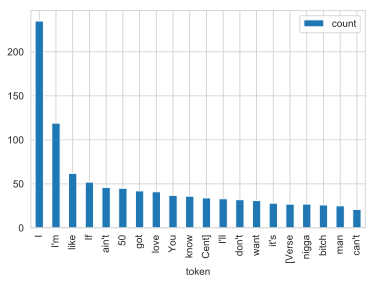

In [88]:
from matplotlib import pyplot as plt

import seaborn as sns

# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');


In [247]:
lyric_df[lyric_df['lyrics']=='Money']

lyric_df[['artist','lyrics', 'Cleaned Text']].sample(2)

,artist,lyrics,Cleaned Text
1,Tool,[Verse 1]\nBlack\nThen\nWhite are\nAll I see\n...,[vers 1] black then white all i see in infanc ...
0,Tool,[Verse 1]\nTheres a shadow just behind me\nShr...,[vers 1] there shadow behind shroud everi step...


In [200]:
def clean_html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def clean_punc(word):
    cleaned = re.sub(r'[?|!|\'|#]', r'', word)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

def text_preprocess(sentence):
    filtered_sentence = []
    for word in sentence.split():
        if word not in stop:
            s = sno.stem(word.lower())
            filtered_sentence.append(s)
        else:
            continue 
    return ' '.join(filtered_sentence)

lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_punc)
lyric_df['lyrics']  = lyric_df['lyrics'].apply(clean_html)
lyric_df['Cleaned Text']  = lyric_df['lyrics'].apply(text_preprocess)



# for sentence in lyric_df['lyrics'].values:
#     filtered_sentence = []
#     sentence = clean_html(sentence)
#     for word in sentence.split():
#         for cleaned_word in clean_punc(word).split():
#             if (cleaned_word.isalpha() and (len(cleaned_word) > 2) and cleaned_word not in stop):
#                 s = (sno.stem(cleaned_word.lower())).encode('utf8')
#                 filtered_sentence.append(s)
#             else:
#                 continue
                 
#     strl = b' '.join(filtered_sentence)
#     final_string.append(strl)

# lyric_df['Cleaned Text'] = final_string

In [201]:
lyric_df
#save to disk

,lyrics,artist,song,Cleaned Text
0,[Verse 1]\nTheres a shadow just behind me\nShr...,Tool,Sober,[vers 1] there shadow behind shroud everi step...
1,[Verse 1]\nBlack\nThen\nWhite are\nAll I see\n...,Tool,Lateralus,[vers 1] black then white all i see in infanc ...
2,[Verse 1: Lil Yachty]\nDont you hate when a bi...,Carnage,Mase in ’97,[vers 1: lil yachty] dont hate bitch think nee...
3,[Chorus: Lil Uzi Vert]\nI turn five to a ten ...,Carnage,WDYW,[chorus: lil uzi vert] i turn five ten i turn ...


In [203]:
cv = CountVectorizer()
df = cv.fit_transform(lyric_df['Cleaned Text'])

count_vect_df_clean = pd.DataFrame(df.todense(), columns=['vec_' + i for i in cv.get_feature_names()])

count_vect_df_clean
# lyric_df = lyric_df.join(count_vect_df_clean)

# lyric_df

,vec_30,vec_40ll,vec_across,vec_actavi,vec_afghanistan,vec_aint,vec_all,vec_alvin,vec_analyz,vec_and,...,vec_woadi,vec_wont,vec_work,vec_worthless,vec_wrappin,vec_xan,vec_yachty,vec_yellow,vec_you,vec_youngin
0,0,0,0,0,0,0,0,0,0,0,...,0,4,1,2,0,0,0,0,0,0
1,0,0,1,0,0,0,2,0,2,3,...,0,0,0,0,0,0,0,2,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,4,0,1,0
3,1,1,0,1,1,1,0,0,0,0,...,8,0,0,0,1,1,0,0,2,1


In [131]:
music_df = lyric_df

#print(artist_df)
#print(music_df)

In [ ]:
#music_df.to_csv("music.csv", index=False)


In [132]:
averaged_df = music_df.drop(['song','lyrics'],axis=1).groupby('artist').mean().reset_index()



In [133]:
from sklearn.metrics.pairwise import cosine_similarity
query='Weezer'
match = averaged_df[averaged_df['artist']==query]
rest_of_entries = averaged_df[averaged_df['artist']!=query].copy()

if match.empty:\
    print('Not Found!')
    #Throw something here
    #return None
print(cosine_similarity(match.loc[:, match.columns != 'artist'],rest_of_entries.loc[:,rest_of_entries.columns!='artist']))
rest_of_entries['similarity'] = cosine_similarity(match.loc[:, match.columns != 'artist'],rest_of_entries.loc[:,rest_of_entries.columns!='artist'])[0]
rest_of_entries

Not Found!


ValueError: Found array with 0 sample(s) (shape=(0, 629)) while a minimum of 1 is required by check_pairwise_arrays.

In [140]:
cosine_similarity(averaged_df.drop('artist',axis=1),averaged_df.drop('artist',axis=1))

array([[1.        , 0.82064323, 0.70700936, ..., 0.74918614, 0.69364512,
        0.6932935 ],
       [0.82064323, 1.        , 0.76728803, ..., 0.74985765, 0.69923893,
        0.67478045],
       [0.70700936, 0.76728803, 1.        , ..., 0.61287631, 0.54991866,
        0.56922461],
       ...,
       [0.74918614, 0.74985765, 0.61287631, ..., 1.        , 0.79791777,
        0.74379076],
       [0.69364512, 0.69923893, 0.54991866, ..., 0.79791777, 1.        ,
        0.7816415 ],
       [0.6932935 , 0.67478045, 0.56922461, ..., 0.74379076, 0.7816415 ,
        1.        ]])

In [134]:
averaged_df

,artist,vec_abajo,vec_allant,vec_alliag,vec_altess,vec_alway,vec_anoth,vec_apart,vec_aprieta,vec_aprè,...,vec_zipett,vec_âge,vec_ça,vec_écout,vec_écrit,vec_éloquent,vec_érigé,vec_était,vec_êtr,vec_île
0,Deorro,0.5,0.0,0.0,0.0,0.5,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hayce Lemsi,0.0,0.5,0.5,1.0,0.0,0.0,0.0,0.0,0.5,...,0.5,0.5,1.0,0.5,0.5,0.5,2.0,1.0,1.0,0.5


In [135]:
def pull_genre(row):
    artist=row['artist'].replace(' ', '%20')
    CLIENT_ID = secrets['spotify_id']
    CLIENT_SECRET = secrets['spotify_secret']

    grant_type = 'client_credentials'
    body_params = {'grant_type' : grant_type}

    url='https://accounts.spotify.com/api/token'
    response = requests.post(url, data=body_params, auth = (CLIENT_ID, CLIENT_SECRET)) 

    token_raw = json.loads(response.text)
    token = token_raw["access_token"]
    headers = {"Authorization": "Bearer {}".format(token)}
    try:
        r = requests.get(url="https://api.spotify.com/v1/search?q={}&type=artist".format(artist), headers=headers)
        ret = json.loads(r.text)
        return ret['artists']['items'][0]['genres']
    except:
        return []

In [136]:
averaged_df['Genre'] = averaged_df.apply(pull_genre,axis=1)
 
#save to disk

#cosine similarities on genre columns. if there is tie, then consine similarity on lyrics


In [137]:
averaged_df

,artist,vec_abajo,vec_allant,vec_alliag,vec_altess,vec_alway,vec_anoth,vec_apart,vec_aprieta,vec_aprè,...,vec_âge,vec_ça,vec_écout,vec_écrit,vec_éloquent,vec_érigé,vec_était,vec_êtr,vec_île,Genre
0,Deorro,0.5,0.0,0.0,0.0,0.5,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[big room, dance pop, deep big room, disco hou..."
1,Hayce Lemsi,0.0,0.5,0.5,1.0,0.0,0.0,0.0,0.0,0.5,...,0.5,1.0,0.5,0.5,0.5,2.0,1.0,1.0,0.5,"[francoton, french hip hop, pop urbaine]"


In [182]:
averaged_df.dtypes

artist        object
vec_00       float64
vec_000      float64
vec_01       float64
vec_02       float64
vec_03       float64
vec_04       float64
vec_05       float64
vec_06       float64
vec_08       float64
vec_09       float64
vec_10       float64
vec_100      float64
vec_1000     float64
vec_100k     float64
vec_101      float64
vec_103      float64
vec_105      float64
vec_106      float64
vec_108      float64
vec_10k      float64
vec_10s      float64
vec_10th     float64
vec_11       float64
vec_110      float64
vec_112      float64
vec_116th    float64
vec_11s      float64
vec_11x      float64
vec_12       float64
              ...   
vec_혹해       float64
vec_혼란스러     float64
vec_홀로       float64
vec_화나면      float64
vec_화만       float64
vec_효도       float64
vec_후회       float64
vec_후회하는     float64
vec_후회하지     float64
vec_훔쳐       float64
vec_훔쳐보다가    float64
vec_흉터들로     float64
vec_흐르게      float64
vec_흐르는      float64
vec_흔들면      float64
vec_흔들어도     float64
vec_흔한       

In [183]:
len(averaged_df)

337

In [210]:
averaged_df.count()

artist       337
vec_00       337
vec_000      337
vec_01       337
vec_02       337
vec_03       337
vec_04       337
vec_05       337
vec_06       337
vec_08       337
vec_09       337
vec_10       337
vec_100      337
vec_1000     337
vec_100k     337
vec_101      337
vec_103      337
vec_105      337
vec_106      337
vec_108      337
vec_10k      337
vec_10s      337
vec_10th     337
vec_11       337
vec_110      337
vec_112      337
vec_116th    337
vec_11s      337
vec_11x      337
vec_12       337
            ... 
vec_혹해       337
vec_혼란스러     337
vec_홀로       337
vec_화나면      337
vec_화만       337
vec_효도       337
vec_후회       337
vec_후회하는     337
vec_후회하지     337
vec_훔쳐       337
vec_훔쳐보다가    337
vec_흉터들로     337
vec_흐르게      337
vec_흐르는      337
vec_흔들면      337
vec_흔들어도     337
vec_흔한       337
vec_흘러       337
vec_흘러가는데    337
vec_흘러가버린    337
vec_흩날릴      337
vec_힘든       337
vec_힘들       337
vec_힘들게      337
vec_힘들어진     337
vec_힘은       337
vec_힘을       337
vec_ﬁxed     3

In [189]:
averaged_df[['Genre','artist']].describe(include=np.object).transpose()

,count,unique,top,freq
Genre,337,280,"[contemporary country, country, country road, ...",12
artist,337,337,Imagine Dragons,1


In [218]:
df_genre_artist = averaged_df[['artist','Genre']]



In [219]:
df_genre_artist.describe().transpose()

,count,unique,top,freq
artist,337,337,Imagine Dragons,1
Genre,337,280,"[contemporary country, country, country road, ...",12


In [224]:
df_genre_artist[['artist']].plot(kind='box', vert=False, figsize=(6,2));

TypeError: Empty 'DataFrame': no numeric data to plot

In [214]:
# cv = CountVectorizer()
# df = cv.fit_transform(lyric_df['Cleaned Text'])

# count_vect_df_clean = pd.DataFrame(df.todense(), columns=['vec_' + i for i in cv.get_feature_names()])
# lyric_df = lyric_df.join(count_vect_df_clean)

# lyric_df
x = df_genre_artist['Genre']

tuple(e) for e in x

df_genre = cv.fit_transform(x)

count_vect_df_genre = pd.DataFrame(df_genre.todense(), columns=['vec_' + i for i in cv.get_feature_names()])

count_vect_df_genre
# df_genre_artist = df_genre_artist.join(count_vect_df_genre)

# df_genre_artist

SyntaxError: invalid syntax (<ipython-input-214-c599c19fdda1>, line 10)

In [217]:
#averaged_df[['Genre']].nunique()

In [89]:
#averaged_df.to_csv("artist.csv", index=False)
#averaged_df = pd.read_csv("artist.csv")


In [238]:
sub_df=lyric_df[lyric_df['lyrics']=='Love']

In [239]:
sub_df

,lyrics,artist,song,Cleaned Text,vec_30,vec_40ll,vec_across,vec_actavi,vec_afghanistan,vec_aint,...,vec_woadi,vec_wont,vec_work,vec_worthless,vec_wrappin,vec_xan,vec_yachty,vec_yellow,vec_you,vec_youngin
